In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

Модель Q обучения

In [2]:
from lerning import QLerning

Импорт моделей:\
__Deck__ - модель колоды (создание колоды и манипуляции над ней);\
__SimpleModel__ - простая игра, размерность матрицы полезности 180x2 (18 состояний на руке игрока, 10 состояний начальной карты диллера, 2 возможных действия);\
__DoubleModel__ - игра с возможностью удвоения, размерность матрицы полезности 180x3 (18 состояний на руке игрока, 10 состояний начальной карты диллера, 3 возможных действия);\
__СountingModel__ - игра с возможностью удвоения и подсчёта карт, размерность матрицы полезности 738x3 (18 состояний на руке игрока, 41 состояние колоды, 3 возможных действия);

In [3]:
from models import Deck, SimpleModel, DoubleModel, СountingModel

In [4]:
def convert_to_char(matrix):
    """Конвертация числовой матрицы в символьную"""
    matr = []
    for i in range(matrix.shape[0]):
        row = []
        for j in range(matrix.shape[1]):
            if matrix[i,j] == 0:
                row.append("Stand")
            if matrix[i,j] == 1:
                row.append("Hit")
            if matrix[i,j] == 2:
                row.append("Double")
            if matrix[i,j] == 3:
                row.append("Split")
        matr.append(row)
    return np.array(matr)

def heatmap_plot(data, dict_var):
    """Отрисовка матрицы действий по матрице полезности"""
    data_labels = convert_to_char(data)
    
    x_len = len(dict_var["x_data_labels"])
    y_len = len(dict_var["y_data_labels"])
    
    fig, ax = plt.subplots(figsize=dict_var["figsize"])
    im = ax.imshow(data, cmap="Set1")
    
    ax.set_xticks(np.arange(x_len))
    ax.set_yticks(np.arange(y_len))

    ax.set_xticklabels(dict_var["x_data_labels"])
    ax.set_yticklabels(dict_var["y_data_labels"])
    
    plt.axis([-0.5, x_len - 0.5, -0.5, y_len - 0.5])

    for i in range(y_len):
        for j in range(x_len):
            text = ax.text(j,
                           i,
                           data_labels[i, j],
                           ha="center",
                           va="center",
                           color="w",
                          )
            
    ax.set_title(dict_var["title"])
    ax.set_xlabel(dict_var["xlabel"])
    ax.set_ylabel(dict_var["ylabel"])
    plt.show()


## Часть 1. Простая стратегия

Простая стратегия: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit.

In [5]:
env = gym.make('Blackjack-v0', natural=False)

def model_(treshhold, n_model):
    """
    Подсчет ожидания среднего выигрыша
        treshhold - порог очков в руке игрока до которого игрок берет дополнительные карты
        n_model - количество партий игры
        """
    sum_ = 0
    
    for i in range(0,n_model):
        state = env.reset()
        done = False
        while not done:
            if state[0] < treshhold:
                new_state, reward, done, _= env.step(1)
                state = new_state
            else:
                new_state, reward, done, _= env.step(0)

        sum_ += reward
    return sum_/n_model

In [6]:
out = []
range_ = np.arange(19,22)
for i in tqdm(range_):
    out.append(model_(i, 100000))

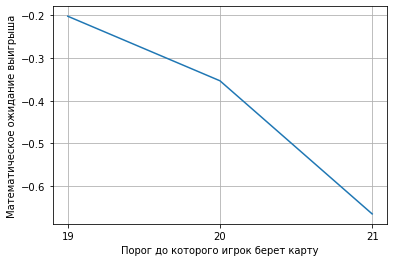

In [7]:
fig, ax = plt.subplots()
ax.plot(range_, np.array(out))
ax.set_xticks(range_)
ax.set_title("")
ax.set_xlabel("Порог до которого игрок берет карту")
ax.set_ylabel("Математическое ожидание выигрыша")
ax.grid()

Обучение модели простой игры (180 состояний, 2 действия)

In [13]:
model_1 = SimpleModel(multiproc_game=False)
ql_1 = QLerning(model_1, alpha=0.1, gamma=0.2, epsilon=0.025)

<IPython.core.display.Javascript object>


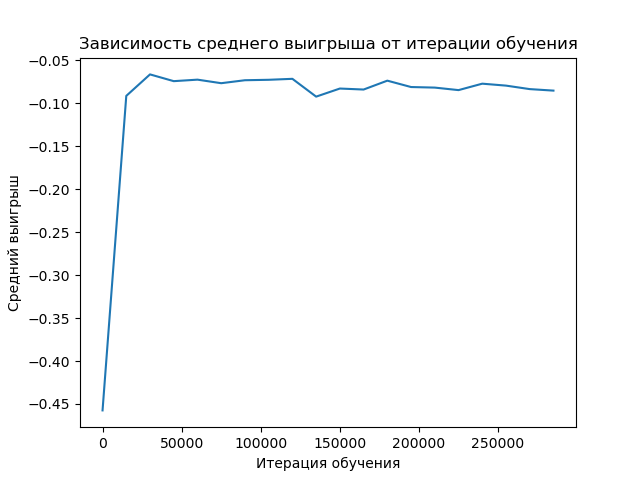

value from best iter = -0.457455
value from best iter = -0.091255
value from best iter = -0.06624

all time best= -0.06624
current value= -0.08512


In [14]:
%matplotlib notebook
ql_1.traning_model(n_train = 300000,
                   show_fit = True,
                   delta_valid = 15000, 
                   n_games = 100000)

Средний выигрыш на последней итерации обучения

In [15]:
ql_1.get_mean_reward()

-0.08512

In [16]:
dict_var_1 = {"x_data_labels":list(map(str, np.arange(4, 22))),
              "y_data_labels":['A', '2', '3', '4', '5', '6', '7', '8', '9', 'J,Q,K'],
              "figsize":(12,8),
              "title":"Стратегии игры",
              "xlabel":"Сумма карт на руках игрока",
              "ylabel":"Первая карта на руках диллера",
              }

Получение матрицы полезности

In [17]:
data_1 = model_1.get_matrix_actions(ql_1.get_matrix_q(), num_col = 18)

Интерпретация матрицы полезности в конце обучения

<IPython.core.display.Javascript object>


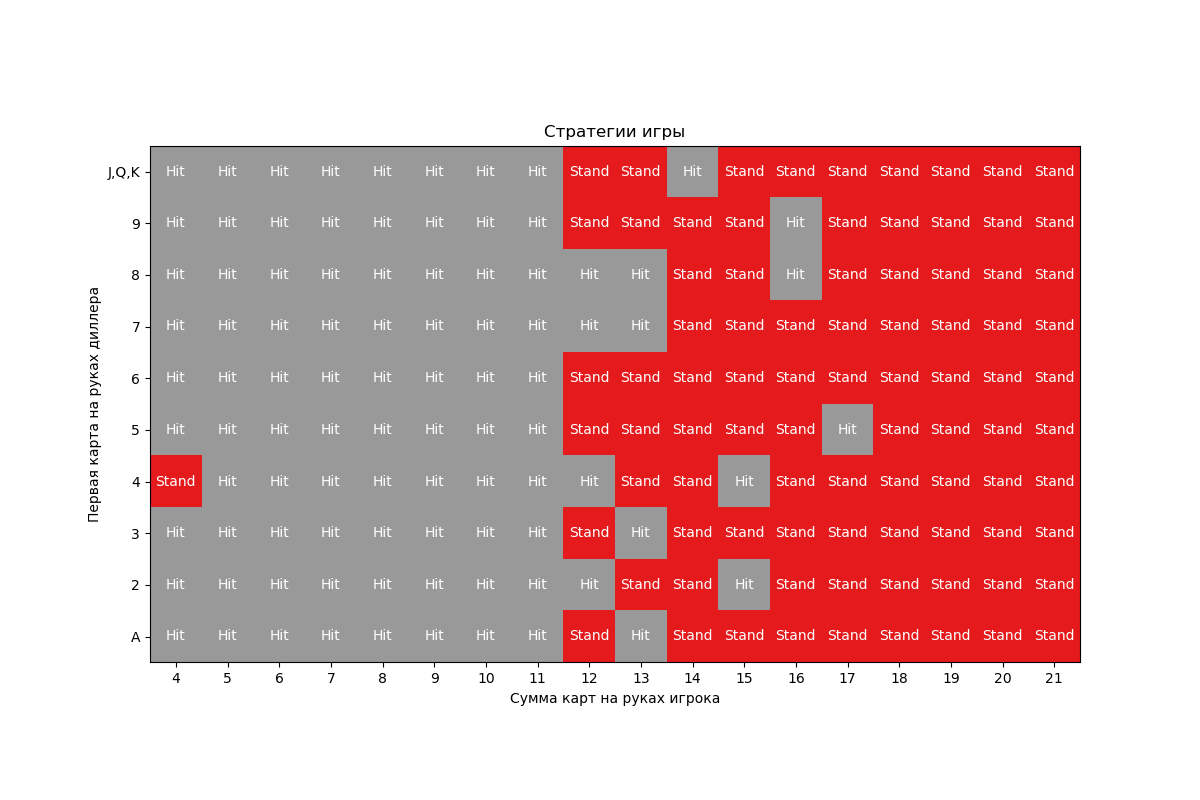

In [18]:
heatmap_plot(data_1, dict_var_1)

## Часть 2. Стратегия с удвоением

Обучение модели простой игры с возможностью удвоения (180 состояний, 3 действия)

In [20]:
model_2 = DoubleModel(multiproc_game=False)
ql_2 = QLerning(model_2, alpha=0.1, gamma=0.3, epsilon=0.025)

<IPython.core.display.Javascript object>


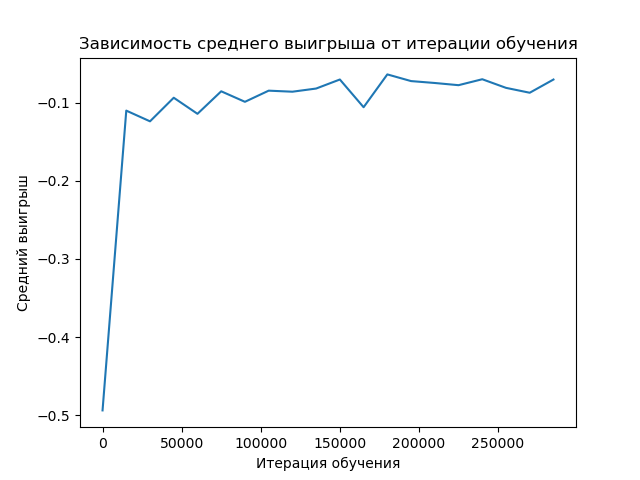

value from best iter = -0.49374
value from best iter = -0.11034
value from best iter = -0.09385
value from best iter = -0.085625
value from best iter = -0.08481
value from best iter = -0.082095
value from best iter = -0.070535
value from best iter = -0.06401

all time best= -0.06401
current value= -0.070575


In [22]:
%matplotlib notebook
ql_2.traning_model(n_train = 300000,
                  show_fit = True,
                  delta_valid = 15000, 
                  n_games = 100000)

Средний выигрыш на последней итерации обучения

In [23]:
ql_2.get_mean_reward()

-0.070575

In [24]:
dict_var_2 = {"x_data_labels":list(map(str, np.arange(4, 22))),
            "y_data_labels":['A', '2', '3', '4', '5', '6', '7', '8', '9', 'J,Q,K'],
            "figsize":(12,8),
            "title":"Стратегии игры",
            "xlabel":"Сумма карт на руках игрока",
            "ylabel":"Первая карта на руках диллера",
           }

Получение матрицы полезности

In [25]:
data_2 = model_2.get_matrix_actions(ql_2.get_matrix_q(), num_col = 18)

Интерпретация матрицы полезности

<IPython.core.display.Javascript object>


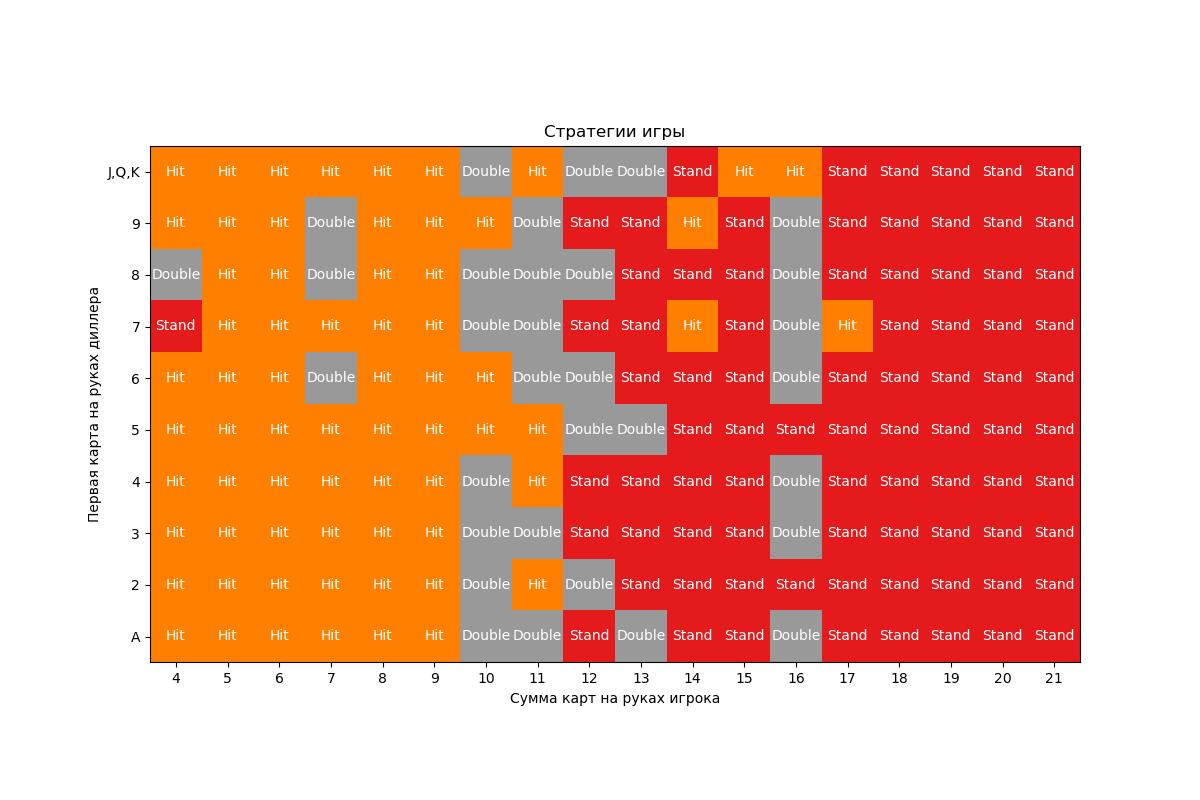

In [26]:
heatmap_plot(data_2, dict_var_2)

## Часть 3. Стратегия с удвоением и подсчетом карт

Обучение модели с возможностью удвоения и подсчётом карт (738 состояний, 3 действия)

In [30]:
model_3 = СountingModel(multiproc_game=False)
ql_3 = QLerning(model_3, alpha=0.1, gamma=0.25, epsilon=0.04)

<IPython.core.display.Javascript object>


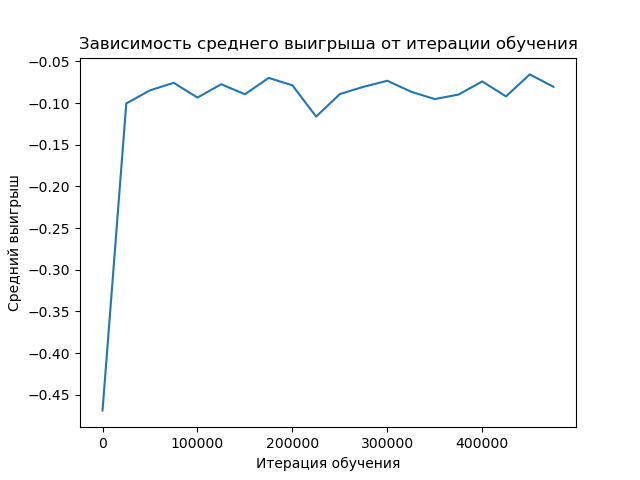

value from best iter = -0.46883
value from best iter = -0.100525
value from best iter = -0.084805
value from best iter = -0.07577
value from best iter = -0.06987
value from best iter = -0.06568

all time best= -0.06568
current value= -0.08049


In [31]:
%matplotlib notebook
ql_3.traning_model(n_train = 500000,
                   show_fit = True,
                   delta_valid = 25000, 
                   n_games = 100000)

Средний выигрыш на последней итерации обучения

In [32]:
ql_3.get_mean_reward()

-0.08049

In [33]:
dict_var_3 = {"x_data_labels":list(map(str, np.arange(4, 22))),
              "y_data_labels":list(map(str, np.arange(-20, 21))),
              "figsize":(20,20),
              "title":"Стратегии игры",
              "xlabel":"Сумма карт на руках игрока",
              "ylabel":"Счёт колоды",
             }

Получение матрицы полезности

In [34]:
data_3 = model_3.get_matrix_actions(ql_3.get_matrix_q(), num_col = 18)

Интерпретация матрицы полезности

<IPython.core.display.Javascript object>


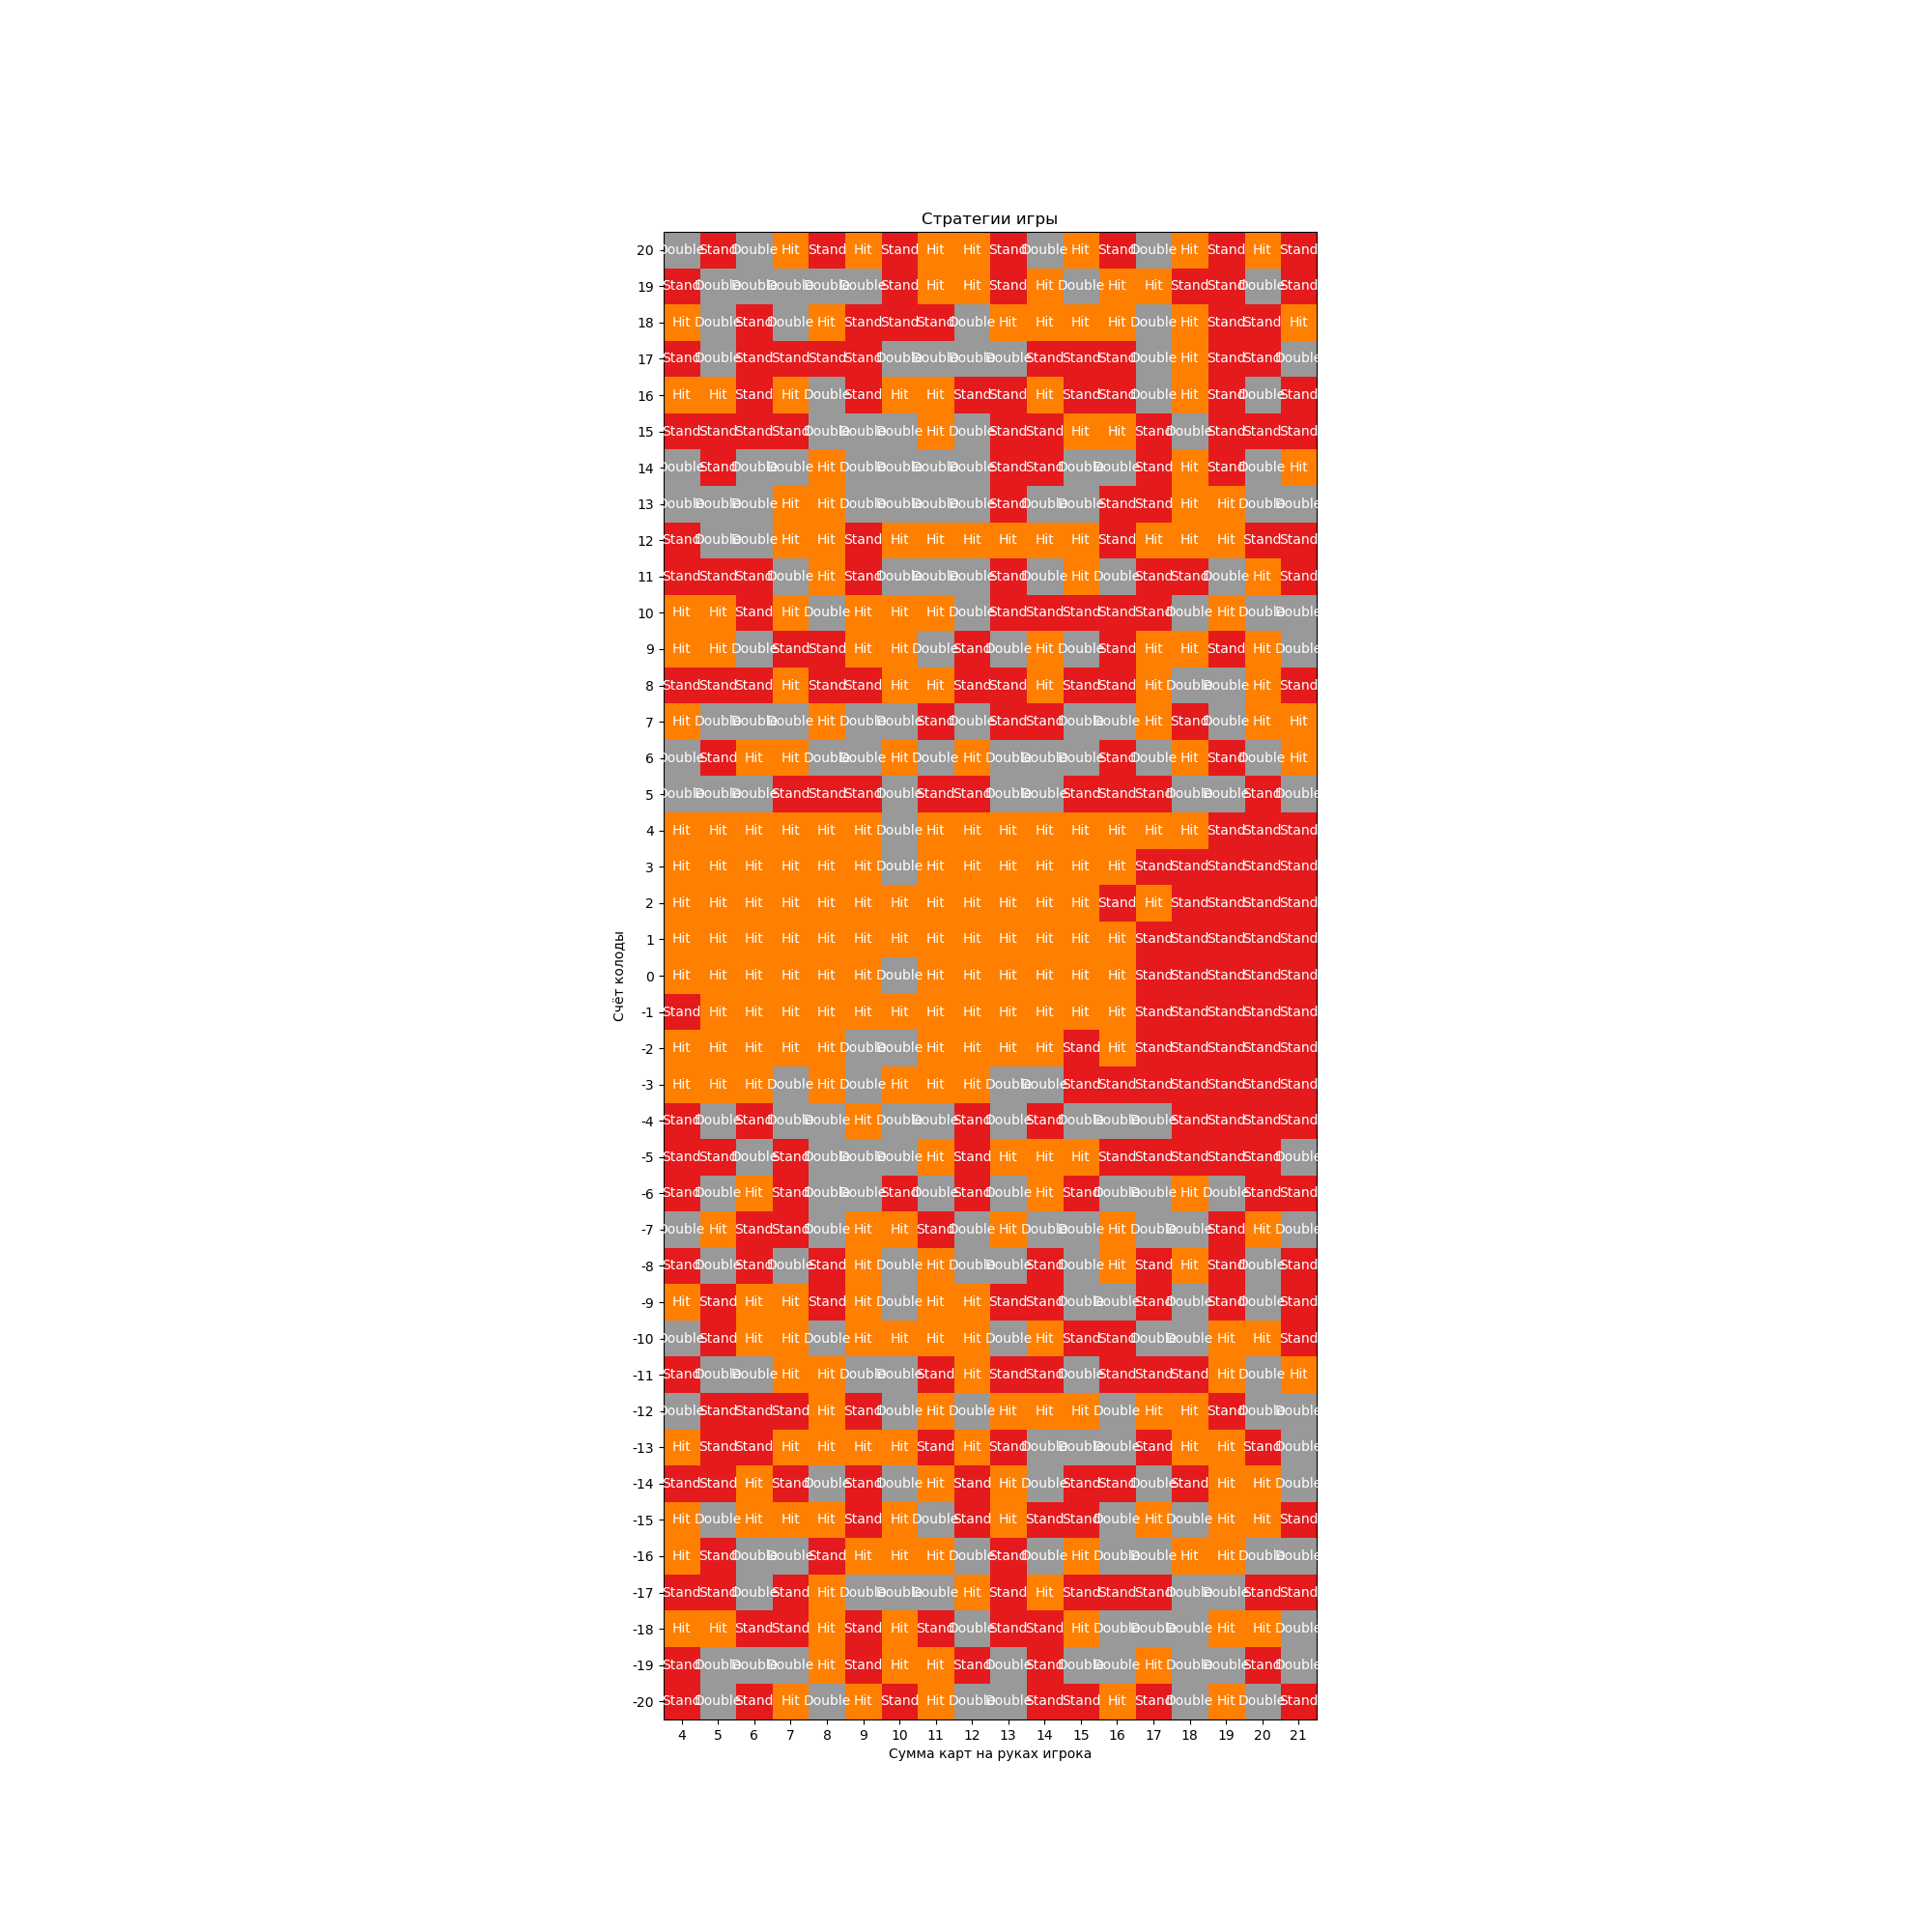

In [35]:
heatmap_plot(data_3, dict_var_3)